In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
#import tensorflow as tf
#import keras

In [ ]:
!pip install --upgrade torchvision>=0.11.8

In [ ]:
#!pip install --upgrade torchvision>=0.11.8
!pip install -q segmentation-models-pytorch==0.3.3
import segmentation_models_pytorch as smp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s eta 0:00:00


In [ ]:


import torch.nn as nn
import torch.backends.cudnn as cudnn
import time
import torch.nn.functional as F
from numpy import *

import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

import torch.utils.data as data
import glob
import imageio
import cv2
import sys
import os.path

#import segmentation_models_pytorch as smp
from sklearn.metrics import f1_score

In [ ]:
!unrar x /content/drive/MyDrive/fixed.rar

Streaming output truncated to the last 5000 lines.
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2728).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2729).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (273).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2730).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2731).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2732).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2733).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2734).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2735).tif      87%  OK 
Extracting  fixed/val/src/GF2_PMS1__L1A0001064454-MSS1__00 (2736).tif      87%  OK 
Extracting  fixed/va

In [ ]:
!unrar x /content/drive/MyDrive/torch_pred.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/torch_pred.rar

Creating    torch_pred                                                OK
Creating    torch_pred/test                                           OK
Creating    torch_pred/test/lab                                       OK
Extracting  torch_pred/test/lab/GF2_PMS2__L1A0000635115-MSS2__2424 (1071).tif       0%  OK 
Extracting  torch_pred/test/lab/GF2_PMS2__L1A0000635115-MSS2__2424 (1328).tif       0%  OK 
Extracting  torch_pred/test/lab/GF2_PMS2__L1A0000635115-MSS2__2424 (1350).tif       0%  OK 
Extracting  torch_pred/test/lab/GF2_PMS2__L1A0000635115-MSS2__2424 (138).tif       0%  OK 
Extracting  torch_pred/test/lab/GF2_PMS2__L1A0000635115-MSS2__2424 (159).tif       0%  OK 
Extracting  torch_pred/test/lab/GF2_PMS2__L1A0000635115-MSS2__2424 (1689).tif       0%  OK 
Extracting  torch_pred/test/lab/GF2_PMS2__L1A0

In [ ]:
train_path = r'/content/fixed/train/'
#train_path = r'/content/DATA_10_KERAS/train/'
x_train_dir = os.path.join(train_path, 'src')
y_train_dir = os.path.join(train_path, 'lab')
num_images = len(os.listdir(x_train_dir))
num_masks=len(os.listdir(y_train_dir))
print(" total number of train images =", num_images)
print(" total number of train masks =",num_masks)

#train_path = r'/content/drive/MyDrive/GID/train/train/'
val_path = r'/content/fixed/val/'
x_val_dir = os.path.join(val_path, 'src')
y_val_dir = os.path.join(val_path, 'lab')
test_path = r'/content/torch_pred/test/'
x_test_dir = os.path.join(test_path, 'src')
y_test_dir = os.path.join(test_path, 'lab')

#PATH= f'/content/drive/MyDrive/output/deep_resnet101/deep_resnet101+{epoch}.pth'
#PATH = '/content/deep_resnet18_{epoch}.pth'


 total number of train images = 33072
 total number of train masks = 33072


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch

In [ ]:

CLASSES = ['industrial land',
  'urban residential','rural residential',
  'traffic land','paddy field','irrigated land', 'dry cropland',
  'garden plot','arbor woodland',
  'shrub land','natural grassland',
  'artificial grassland','river/lake','pond']

CLASSES

['industrial land',
 'urban residential',
 'rural residential',
 'traffic land',
 'paddy field',
 'irrigated land',
 'dry cropland',
 'garden plot',
 'arbor woodland',
 'shrub land',
 'natural grassland',
 'artificial grassland',
 'river/lake',
 'pond']

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """



    def __init__(
            self,
            images_dir,
            masks_dir,
            classes=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        mask = np.where(mask == 7, 6, mask)
        mask = np.where(mask == 13, 12, mask)
        mask = np.where(6 < mask, np.where(mask < 12, mask-1, mask), mask)
        mask = np.where(mask > 12, mask-2, mask)

        # mask = torch.from_numpy(np.array(mask).reshape(256, 256)).type(torch.LongTensor)
        # mask = torch.nn.functional.one_hot(mask, num_classes=16).to(torch.float32).cpu().numpy()
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)

    def foo(self):
        print(self.class_values)

In [ ]:
# helper function for data visualization
def visualize(image, gt, pred_mask):
    """PLot images in one row."""
    if pred_mask != None:
      plt.figure(figsize=(16, 5))
      plt.subplot(1, 3, 1)
      plt.title('Image')
      plt.imshow(image)
      plt.subplot(1, 3, 2)
      plt.title('GT')
      plt.imshow(np.argmax(gt, axis=-1).reshape(256, 256, 1))
      plt.subplot(1, 3, 3)
      plt.title('Prediction')
      plt.imshow(np.argmax(pred_mask, axis=-1).reshape(256, 256, 1))
    else:
      plt.figure(figsize=(16, 5))
      plt.subplot(1, 2, 1)
      plt.title('Image')
      plt.imshow(image)
      plt.subplot(1, 2, 2)
      plt.title('GT')
      plt.imshow(np.argmax(gt, axis=-1).reshape(256, 256, 1))
    plt.show()


(256, 256, 14)


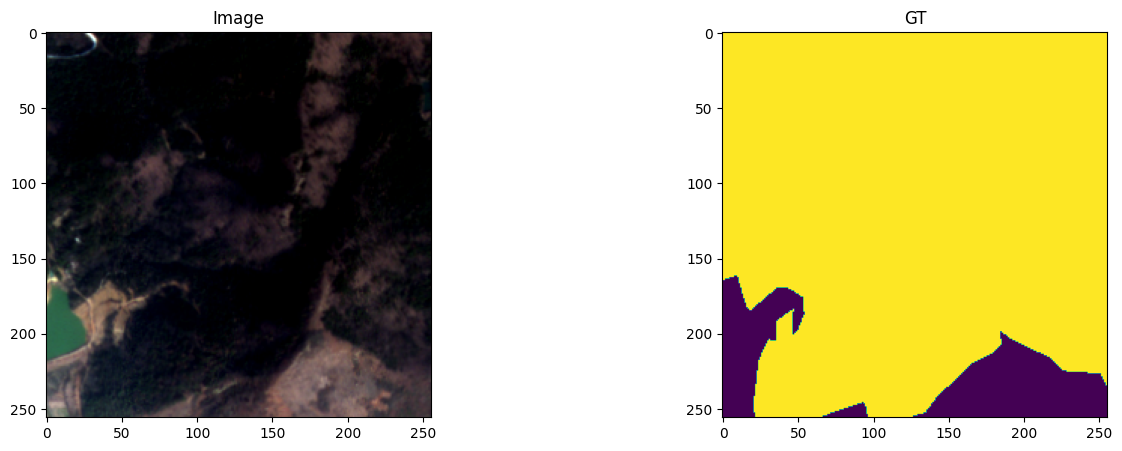

(256, 256, 14)


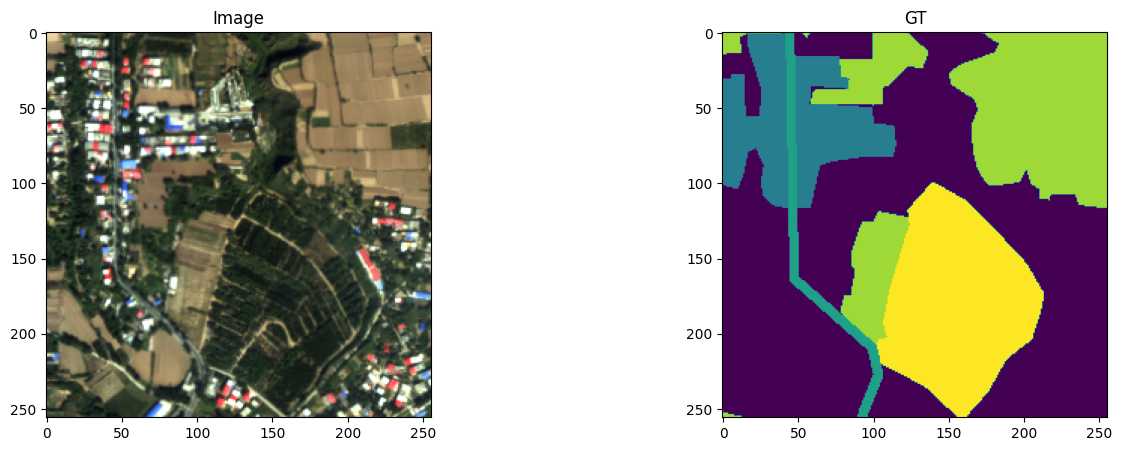

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['industrial land',
          'urban residential','rural residential',
          'traffic land','paddy field','irrigated land', 'dry cropland',
          'garden plot','arbor woodland',
          'shrub land','natural grassland',
          'artificial grassland','river/lake','pond'])

for i in range(2):
  image, mask = dataset[i]
  print(mask.shape)
  visualize(image=image, gt=mask, pred_mask=None)


In [ ]:
dataset.foo()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        albu.RandomCrop(height=256, width=256, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(256, 256)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:263: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:386: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:233: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.10/dist-packages/alb

(256, 256, 14)


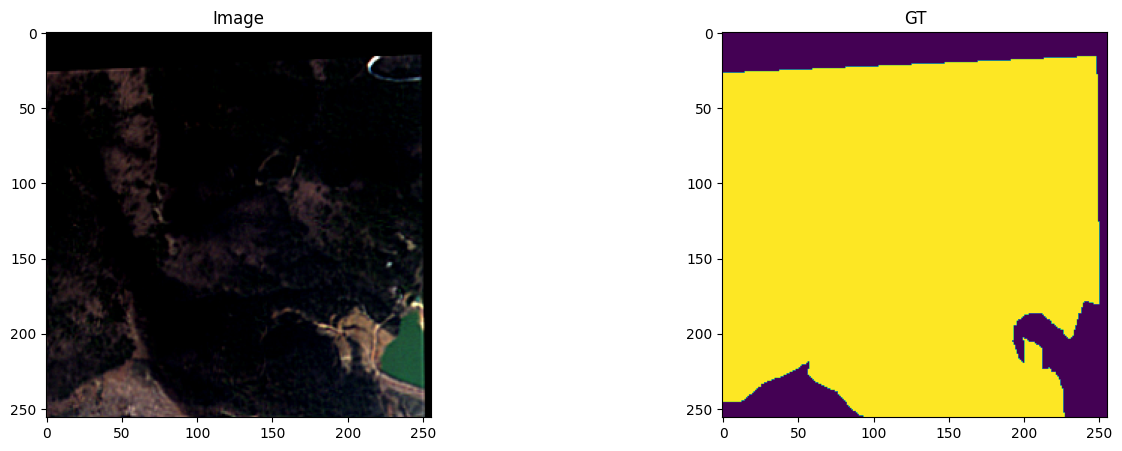

(256, 256, 14)


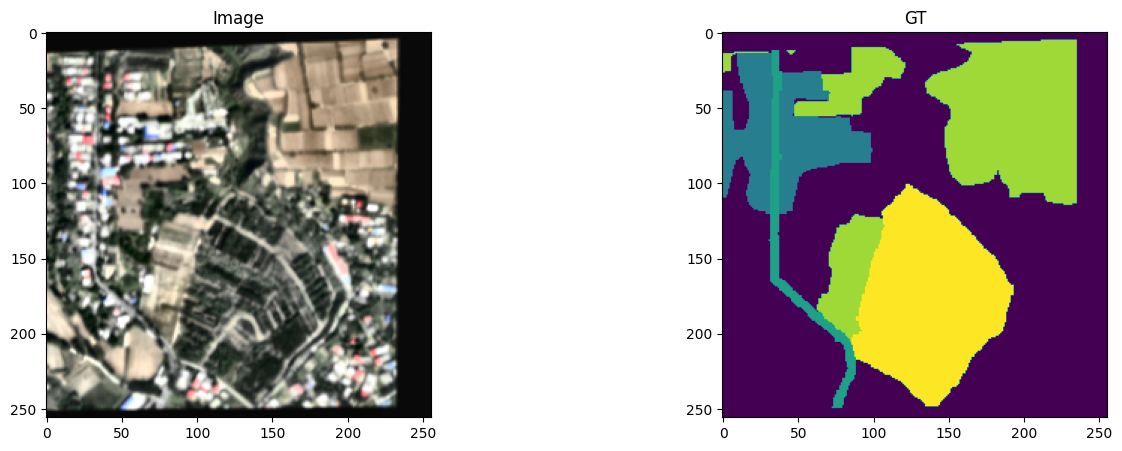

In [ ]:
# augmented_dataset = Dataset(
#     x_train_dir,
#     y_train_dir,
#     augmentation=get_training_augmentation(),
#     classes=['urban residential'],
# )
dataset = Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation(), classes=['industrial land',
          'urban residential','rural residential',
          'traffic land','paddy field','irrigated land', 'dry cropland',
          'garden plot','arbor woodland',
          'shrub land','natural grassland',
          'artificial grassland','river/lake','pond'])

for i in range(2):
  image, mask = dataset[i]
  print(mask.shape)
  visualize(image=image, gt=mask, pred_mask=None)




In [ ]:
import torch
CLASSES = ['industrial land',
          'urban residential','rural residential',
          'traffic land','paddy field','irrigated land', 'dry cropland',
          'garden plot','arbor woodland',
          'shrub land','natural grassland',
          'artificial grassland','river/lake','pond']

ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'

# create segmentation model with pretrained encoder

model = smp.DeepLabV3Plus(encoder_name='efficientnet-b3', classes=len(CLASSES), activation=ACTIVATION)

model=torch.load('/content/drive/MyDrive/output/merged_eff_best_model_ready.pth')
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:01<00:00, 47.8MB/s]


In [ ]:
train_dataset = Dataset(
    x_train_dir,
    y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_val_dir,
    y_val_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
!pip -q install torchmetrics
import segmentation_models_pytorch.utils.metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import torch
#import torchmetrics

#loss = nn.CrossEntropyLoss()

loss = smp.utils.losses.DiceLoss()+ smp.utils.losses.BCELoss()

#metrics =torchmetrics.Accuracy()

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
import torch
# import our library
import torchmetrics
import segmentation_models_pytorch.utils.metrics

# initialize metric
#acc = torchmetrics.Accuracy(task="multiclass", num_classes=16)
acc=smp.utils.metrics.Accuracy(threshold=0.5)
iou= smp.utils.metrics.IoU(threshold=0.5)
f1=smp.utils.metrics.Fscore(beta=1,threshold=0.5)
pre=smp.utils.metrics.Recall(threshold=0.5)
recal=smp.utils.metrics. Precision(threshold=0.5)
metrics=[acc,iou,f1,pre,recal]

In [ ]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
# load best saved checkpoint
best_model = torch.load('/content/drive/MyDrive/output/merged_eff_best_model_ready.pth')
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset,batch_size=16, shuffle=False, num_workers=0)
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

#logs = test_epoch.run(test_dataloader)

In [ ]:
best_model = torch.load('/content/drive/MyDrive/output/merged_eff_best_model_ready.pth')

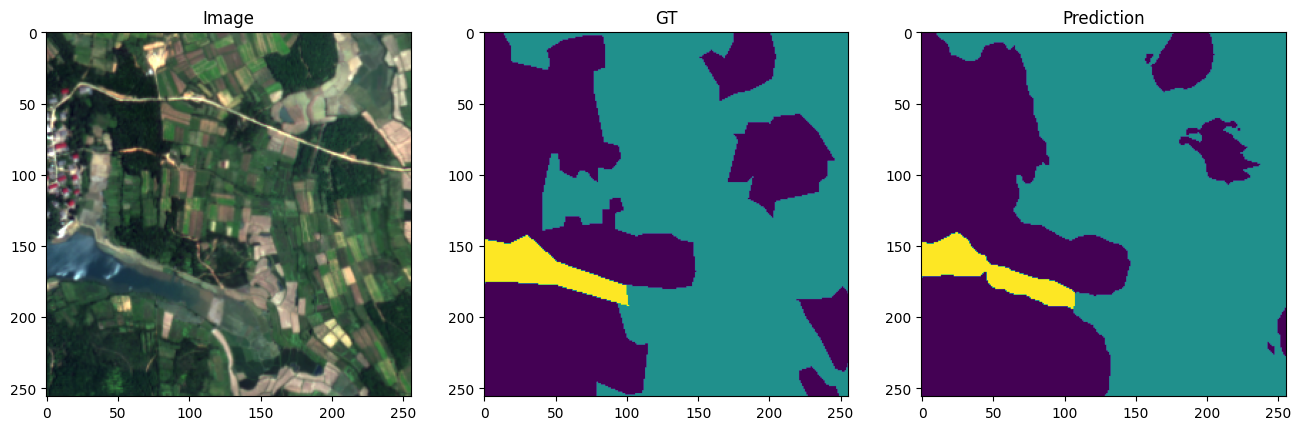

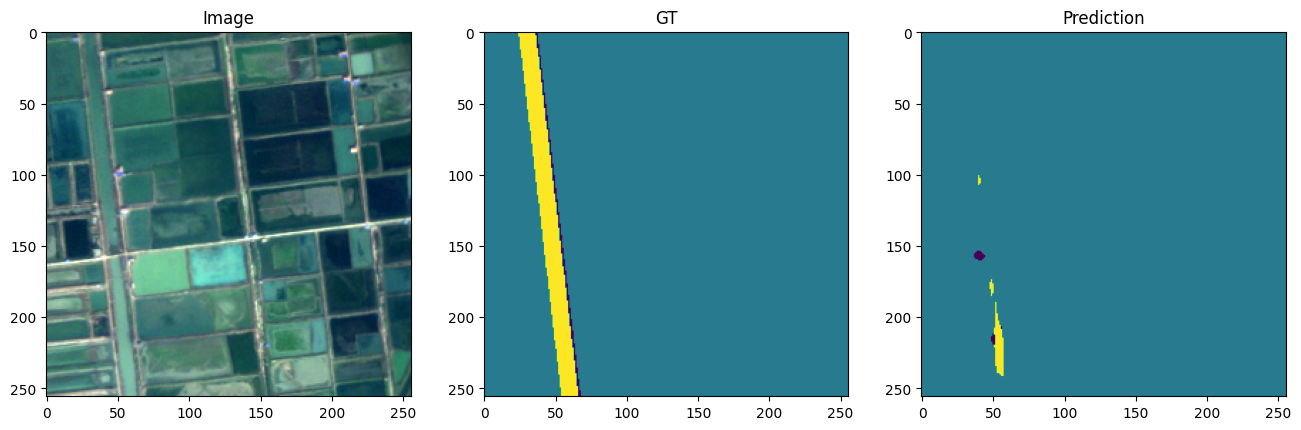

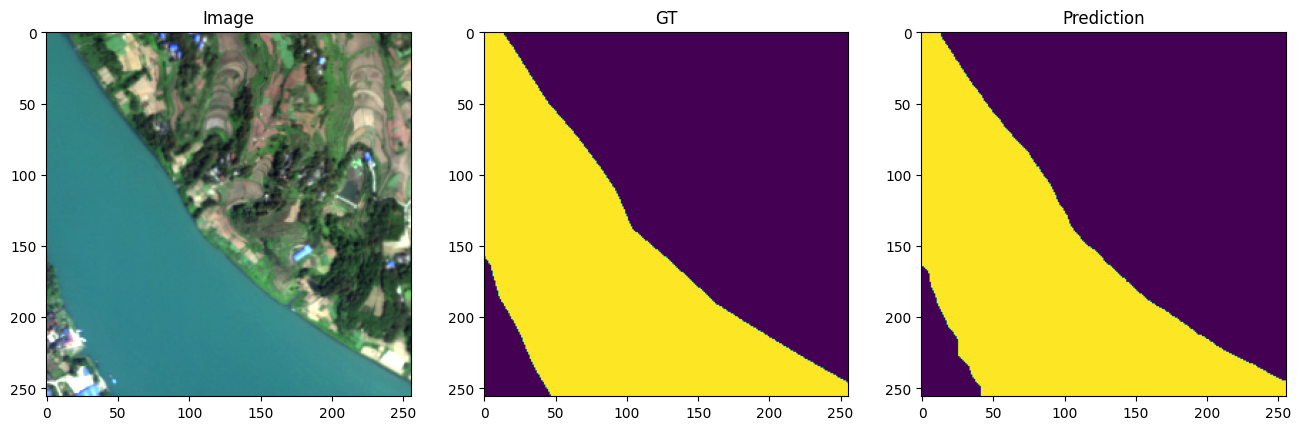

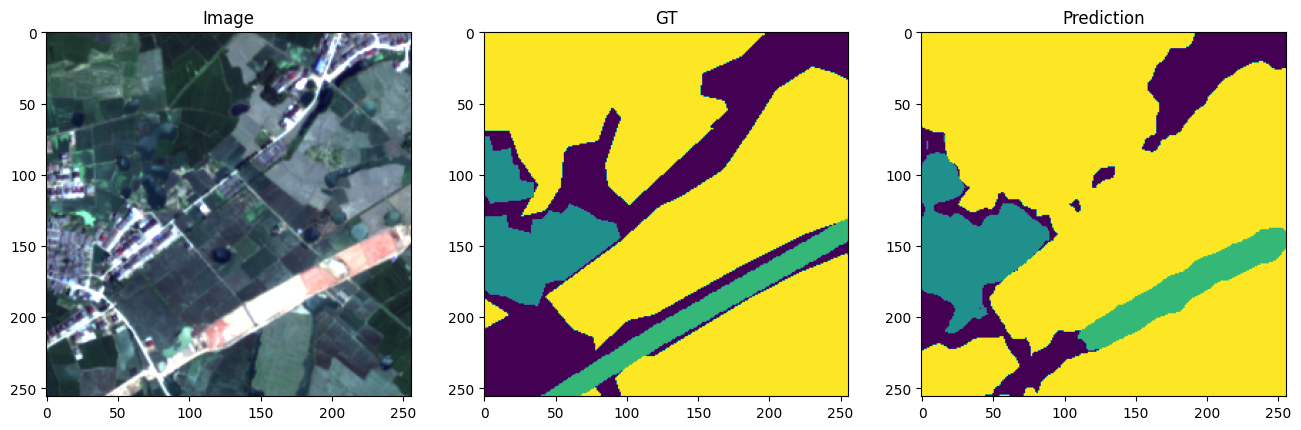

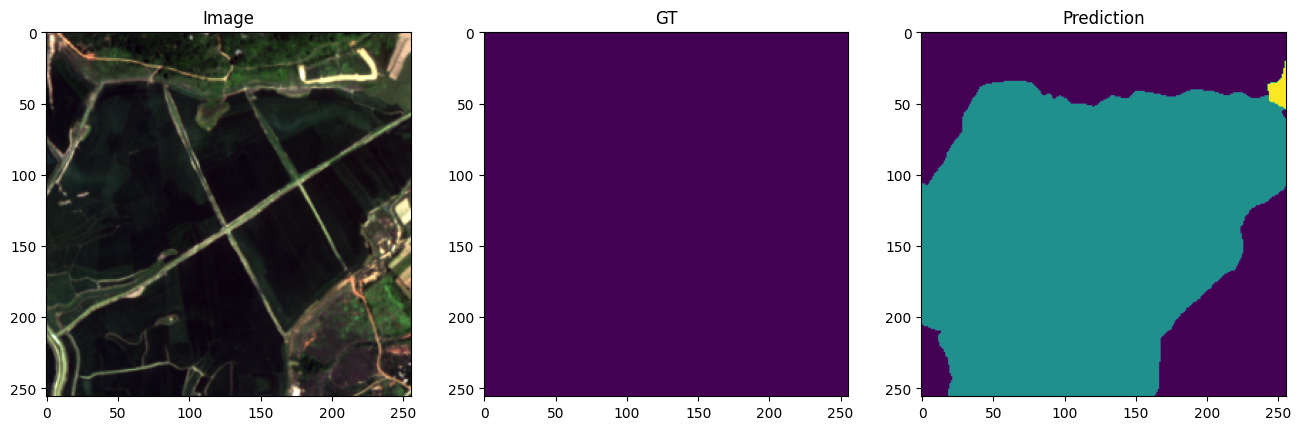

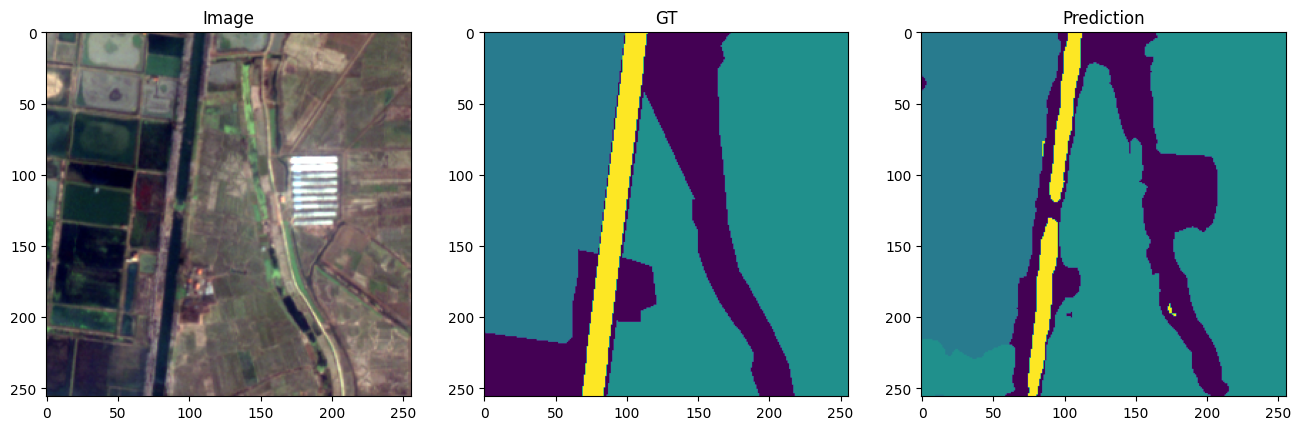

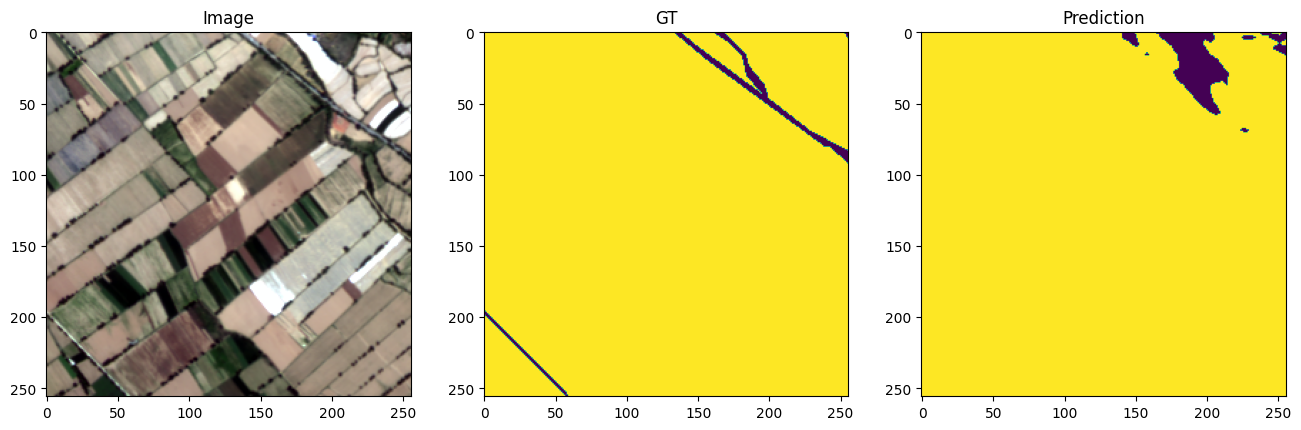

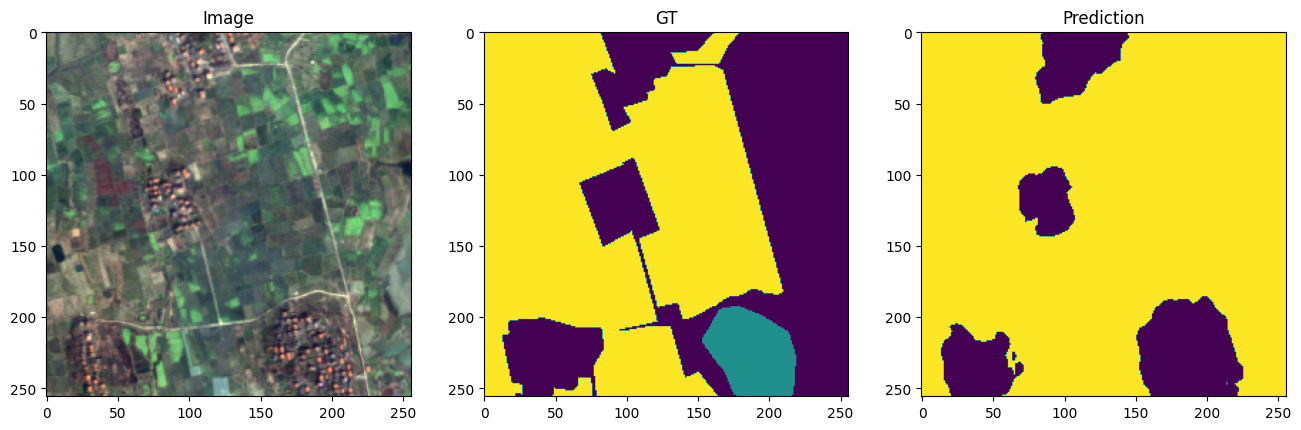

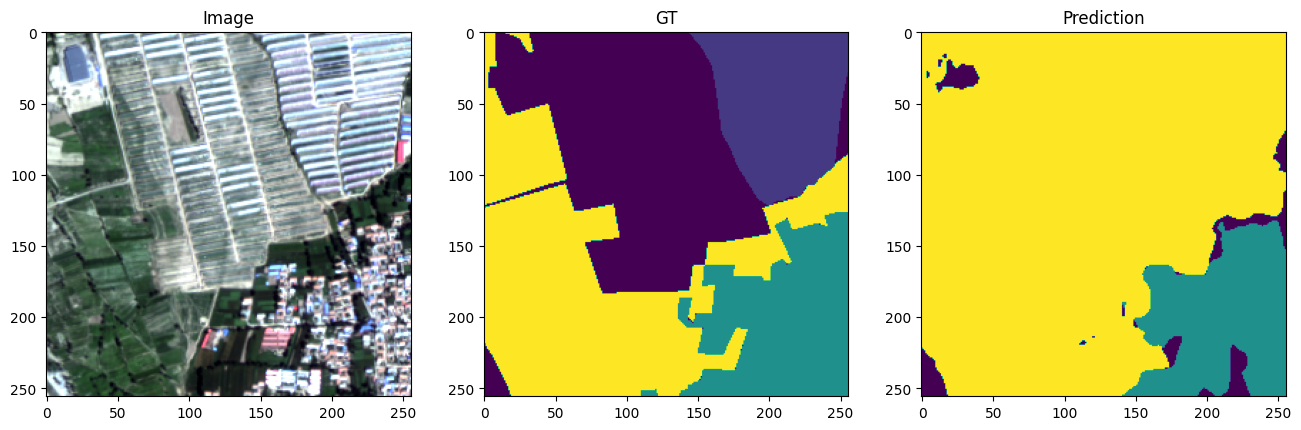

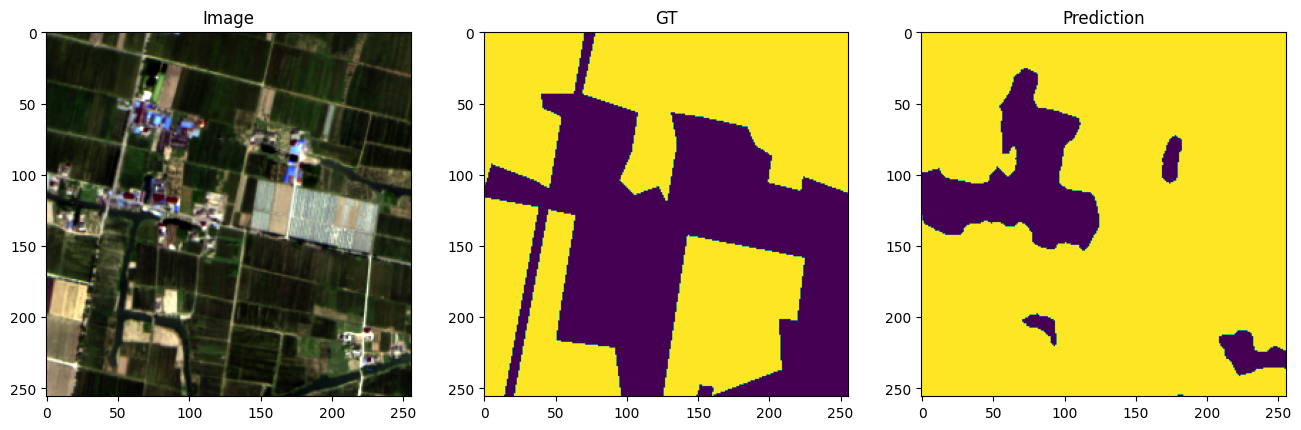

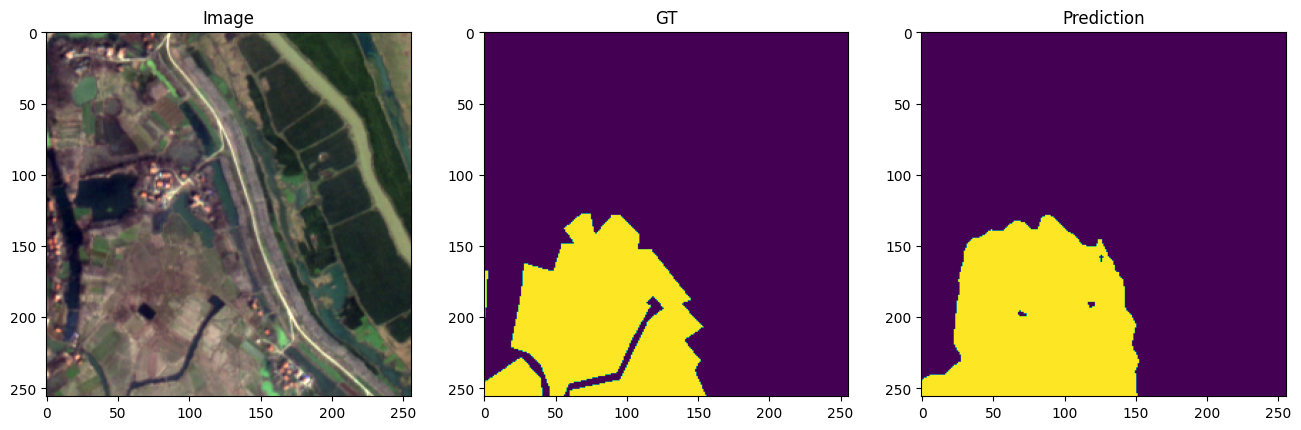

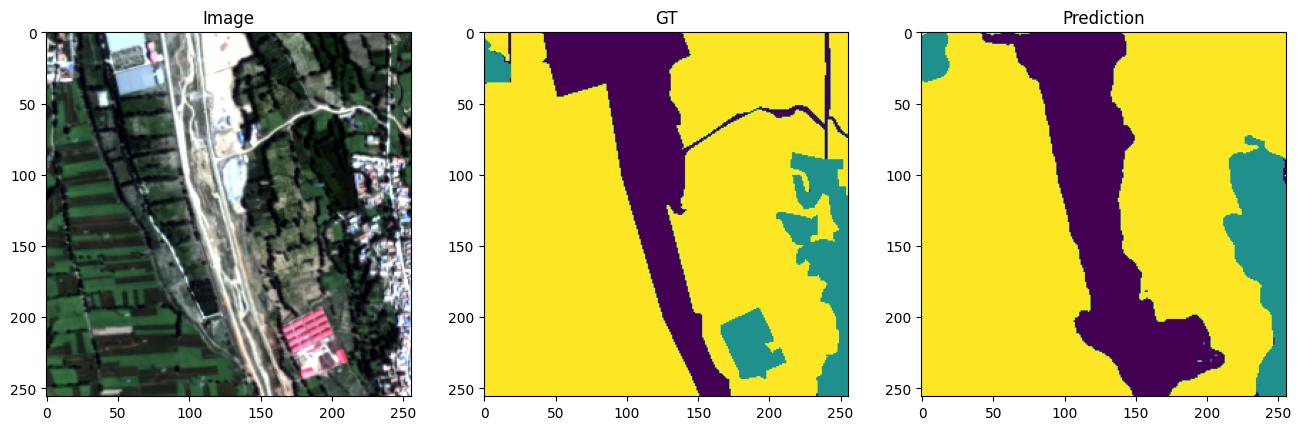

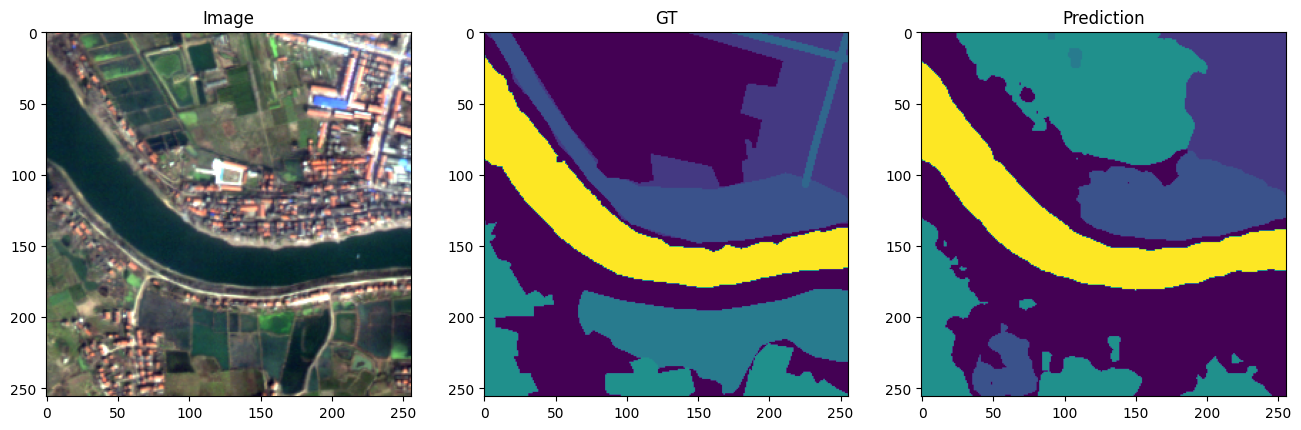

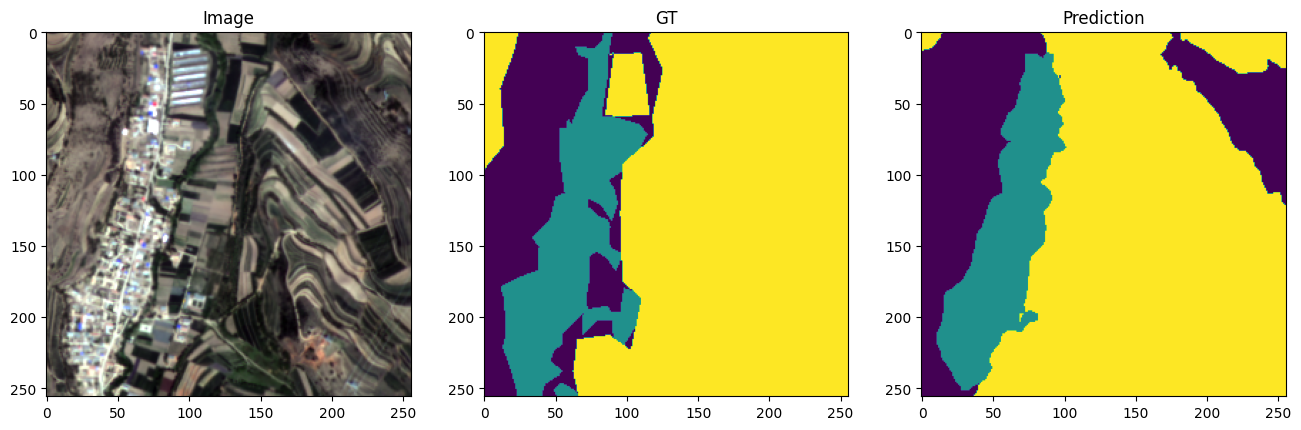

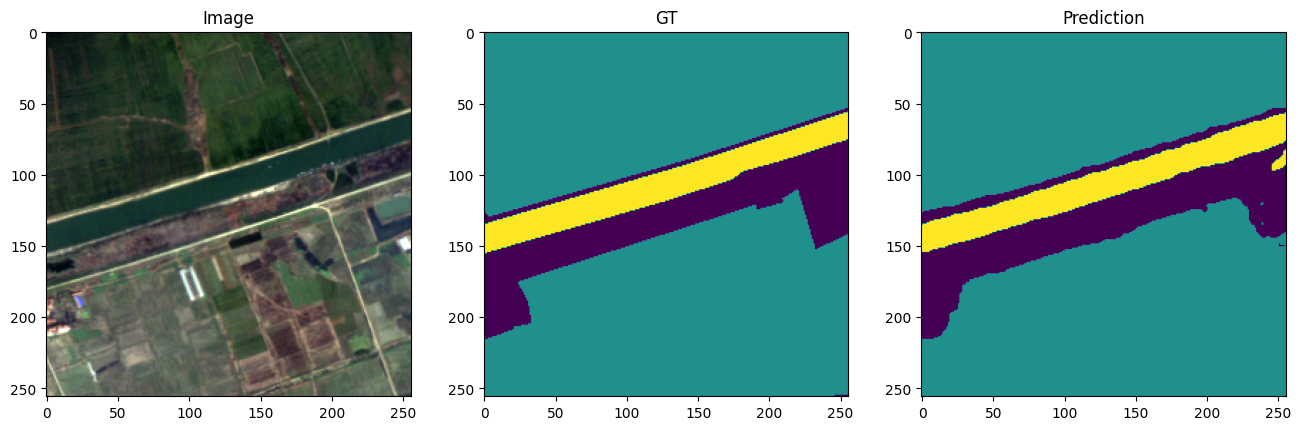

In [ ]:
#revised

device ='cpu'  #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model.to(device)
best_model.eval()
meanD = [0.485, 0.456, 0.406]
stdD = [0.229, 0.224, 0.225]
import matplotlib.pyplot as plt
with torch.no_grad():
  for i in range(0, 15):
    image, mask = test_dataset[i]
    x_tensor = torch.from_numpy(image).to('cpu').unsqueeze(0)
    # print(x_tensor.shape, x_tensor.permute([0, 3, 1, 2]).shape)
    pr_mask = best_model.predict(x_tensor.type(torch.FloatTensor))
    image=(image.transpose([1,2,0])*stdD) + meanD

    visualize(image=image, gt=mask.transpose([1,2,0]), pred_mask=pr_mask.permute([0, 2, 3, 1]).reshape(256, 256, 14))
   #